### Library import

In [2]:
import math
import torch
import random
from graphviz import Digraph

### Graphviz

In [5]:
def trace(last_node:Value):
    nodes, edges = set(), set()
    def build(node:Value):
        if node not in nodes:
            nodes.add(node)
            for parent in node.predecesors:
                edges.add((parent, node))
                build(parent)
    build(last_node)
    return nodes, edges

def draw_dot(last_node:Value, format = "svg", rankdir="LR"):
    '''
    format: "svg", "png", etc.
    rankdir: TB (top to bottom) | LR (left to right)
    '''
    
    assert rankdir in ("LR", "TB")
    nodes, edges = trace(last_node=last_node)
    dot = Digraph(format = format, graph_attr = {"rankdir": rankdir})
    
    for node in nodes:
        dot.node(
			name=str(id(node)),
			label=f"Data = {node.data} | grad = {node.grad}",
			shape="record",
		)
        
        if node.op:
            dot.node(
                name=str(id(node)) + node.op,
                label=node.op,
            )
            dot.edge(str(id(node)) + node.op, str(id(node)))
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
        
    return dot

### Value Class

In [3]:
class Value:
    
    def __init__(self, data, inputs = (), op = "", label = ""):
        self.data = data
        self.predecesors = set(inputs)
        self.op = op
        self.grad = 0
        self.label = label
        self.backward = lambda: None
        
    def __repr__(self) -> str:
        if self.label:
            return (f"data of {self.label} = {self.data}; gradient = {self.grad}")
        return (f"data = {self.data}; gradient = {self.grad}")
    
    def __radd__(self, other):
        return self + other
    
    def __add__(self, other):
        # check if other is a data:
        other = other if isinstance(other, Value) else Value(other)
        
        # calculate the gradient for addition
        def backward():
            self.grad += out.grad
            other.grad += out.grad
        
        # calculate the output of operation and assign it's local gradient 
        out =  Value(data = self.data + other.data, inputs=(self, other), op = "+")
        out.backward = backward
        
        #return the value
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    def __rmul__(self, other): # called on other * self, when self is not a number
        return self * other
    
    def __mul__(self, other):
        # check if other is a Value
        other = other if isinstance(other, Value) else Value(other)
        
        # calculate the _gradient for multiplication
        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        # calculate the outpout of the operation and assign it it's respective backward function
        out = Value(data = self.data * other.data, inputs=(self, other), op = "*")
        out.backward = backward
        
        # return the output
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __rtruediv__(self, other):
        return self * other**(-1)
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)) # this function only work with other
        
        out = Value(data = pow(self.data, other), inputs=(self,), op = "**")
        
        def backward():
            self.grad += other * pow(self.data, other-1) * out.grad
        
        out.backward = backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(data = math.exp(x),inputs=(self,), op="exp")
        def backward():
            self.grad += out.data * out.grad
        out.backward = backward
        return out
    
    def tanh(self):
        x = self.data
        e = math.exp(2*x)
        out = Value(
            data=((e-1)/(e+1)),
            inputs=(self,),
            op="tanh",
        )
        
        def backward():
            self.grad += (1 - out.data**2) * out.grad
    
        out.backward = backward
        
        return out
    
    def backPropagation(self):
        '''
        Start the backpropagation from this node
        '''
        
        # set the gradient of this node to 1
        self.grad = 1
        
        # build a helper function to create the topological sorting of the graph
        def topologicalSorting(node):
            # create local variable
            L = []
            s = set()
            
            # recursive sorting
            def topo(node:Value):
                if node not in s:
                    s.add(node)
                    for parent in node.predecesors:
                        topo(parent)
                    L.append(node)
            topo(node)
            return L
        
        # call the backward method on each node, starting from the last one
        for node in topologicalSorting(self)[::-1]:
            node.backward()
        

### Neuron, Layer and MLP

In [56]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b).tanh()
        return activation
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        activation = [n(x) for n in self.neurons]
        return activation[0] if len(activation) == 1 else activation
    
    def parameters(self):
        return [params_neuron for neuron in self.neurons for params_neuron in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin:int, nouts:list):
        io = [nin] + nouts
        self.layers = [Layer(io[n], io[n+1]) for n in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [layer_parameters for layer in self.layers for layer_parameters in layer.parameters()]


### Test

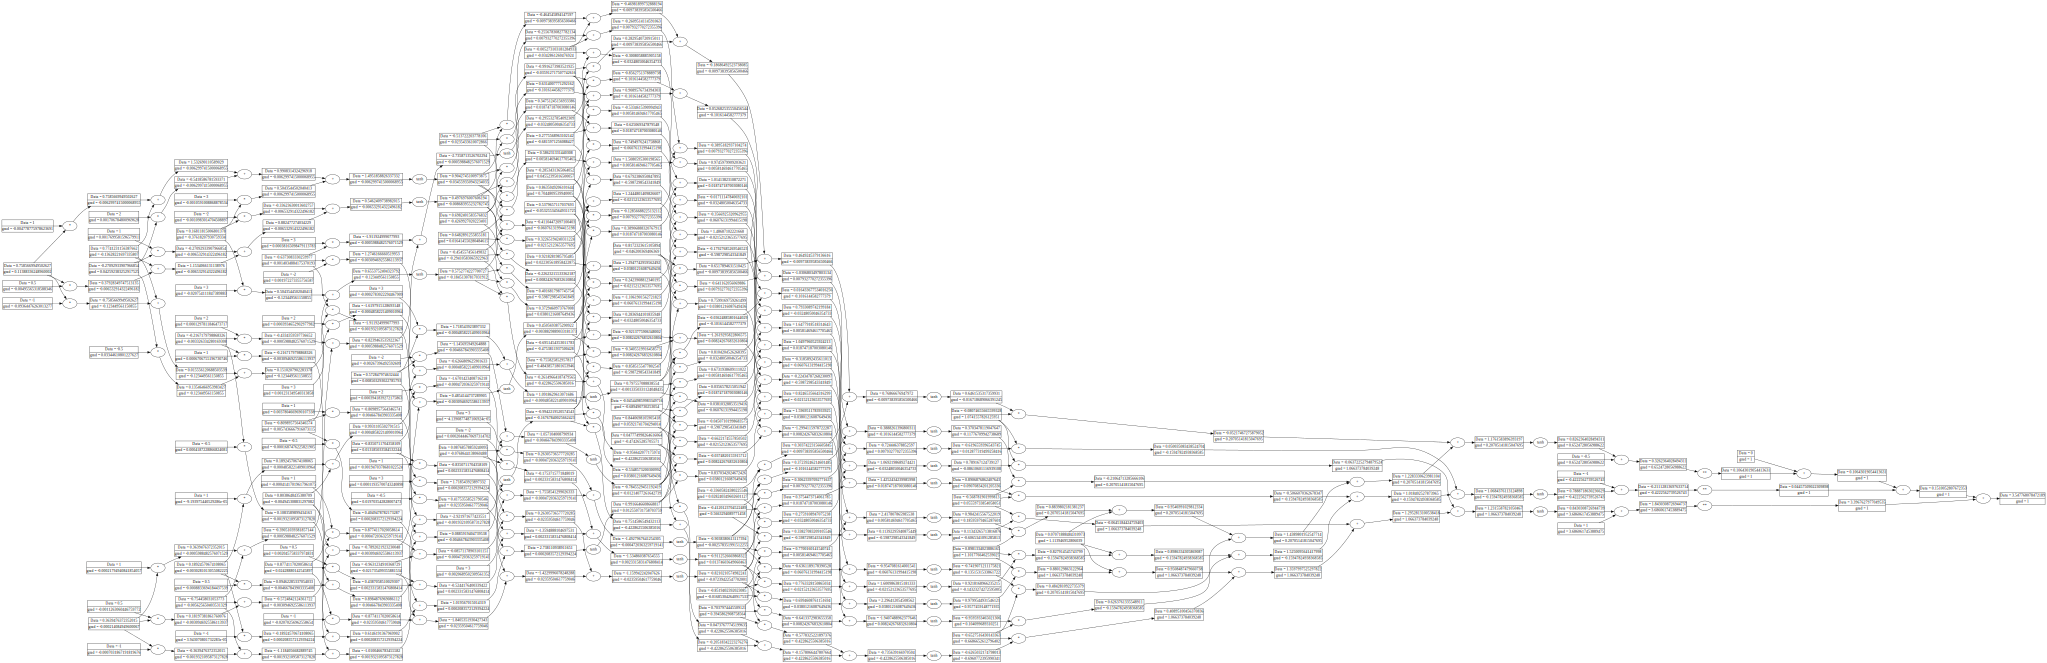

In [60]:
# test activation for a neuron
neuron = Neuron(3)
neuron((1,2,3))

# test activation for a layer
layer = Layer(3,4)
layer((1,2,3))

# Neural network instance
nn = MLP(3,[4,4,1])

# Activation
xs = [
    [1,2,3],
    [0.5,1,-2],
    [-1,-0.5,3]
    ]
ys = [0.5,1,-1]
yhat = [nn(x) for x in xs]
yhat[0]

# calculate loss function
loss = sum((yp-yt)**2 for yp, yt in zip(yhat, ys))

# backpropagation
loss.backPropagation()
draw_dot(loss)

### Train the network

In [141]:
# New Neural network instance
nn = MLP(3,[4,4,1])

# Inputs
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [.5,1,1],
    [1,1-1]
    ]

# target
ys = [1, -1, -1, 1]

# Train the NN
steps = 100
learningRate = 0.1
for step in range(steps):
    # forward pass
    yhat = [nn(x) for x in xs]
    loss = sum((ypred - ytrue)**2 for ypred, ytrue in zip(yhat, ys))

    # reset the grad to 0
    for parameter in nn.parameters():
        parameter.grad = 0.0
    
    # backward pass
    loss.backPropagation()
    for parameter in nn.parameters():
        parameter.data += -(learningRate) * parameter.grad
    
    # print the progress
    print(f"Step {step+1}: Loss = {loss.data}")

# print the final prediction
print(f"Final prediction: {[y.data for y in yhat]}")

Step 1: Loss = 3.8509110336706325
Step 2: Loss = 3.60969157605844
Step 3: Loss = 3.9043621066310914
Step 4: Loss = 5.052900661067444
Step 5: Loss = 3.8097359772883292
Step 6: Loss = 1.9305159823054598
Step 7: Loss = 1.3262974844835917
Step 8: Loss = 0.9974009487327911
Step 9: Loss = 1.8215670395214765
Step 10: Loss = 3.978906907409826
Step 11: Loss = 3.812594150069293
Step 12: Loss = 3.6793781430040506
Step 13: Loss = 3.4221885913308467
Step 14: Loss = 2.7555620025435807
Step 15: Loss = 1.5647718239122441
Step 16: Loss = 0.951501303044907
Step 17: Loss = 0.4666562594738929
Step 18: Loss = 0.25682576103319743
Step 19: Loss = 0.16984072635649827
Step 20: Loss = 0.12574748782962983
Step 21: Loss = 0.09955571593107133
Step 22: Loss = 0.08225392463471587
Step 23: Loss = 0.06996190659919133
Step 24: Loss = 0.06076702428000451
Step 25: Loss = 0.05362390966270743
Step 26: Loss = 0.04791320822787225
Step 27: Loss = 0.04324395563634866
Step 28: Loss = 0.03935659261868138
Step 29: Loss = 0.036071